# Exploratory analysis : NLP FOMC Project

In [126]:
#!pip install wordcloud

In [148]:
import numpy as np
import pandas as pd
from urllib import request
import bs4
from wordcloud import WordCloud, STOPWORDS 
from tqdm.notebook import trange
import matplotlib.pyplot as plt
import re
import itertools
import datetime as dt

In [149]:
df1 = pd.read_csv("/Users/h2jw/Documents/GitHub/NLP-FOMC/updated_version_6.csv", low_memory=True)

In [150]:
df1.Date = df1.Date.astype('datetime64')
df1.statement = df1.statement.fillna("")
df1 = df1.dropna(axis=1)
df1[df1.Date.dt.year == 2015]

,Unnamed: 0,Unnamed: 0.1,Date,interlocutor_name,statement _size,statement,statement_number,chair_in_charge,score_academ,score_hostile,score_econo,score_virtue,score_vice,score_hawkish,score_posi,score_affi,score_uncert
126782,126782,126782,2015-03-18,CHAIR YELLEN.,738,Good morning everybody. As you know we had a f...,statement_0,CHAIR YELLEN,0.0,0.0,0.017291,0.014409,0.002882,0.0,0.500000,1.0,-0.005764
126783,126783,126783,2015-03-18,MR. FISCHER.,4,So moved Madam Chair.,statement_1,CHAIR YELLEN,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
126784,126784,126784,2015-03-18,CHAIR YELLEN.,17,Thank you. Without objection. I am going to ca...,statement_2,CHAIR YELLEN,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
126785,126785,126785,2015-03-18,MR. POTTER.,1467,1 Thank you Madam Chair. We will be splitting ...,statement_3,CHAIR YELLEN,0.0,0.0,0.041480,0.007848,0.013453,0.0,-0.565217,-1.0,-0.023543
126786,126786,126786,2015-03-18,CHAIR YELLEN.,3,Questions? President Kocherlakota.,statement_4,CHAIR YELLEN,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156134,156134,156134,2015-12-16,CHAIR YELLEN.,9,You mean that you can ask a question that,statement_2502,CHAIR YELLEN,0.0,0.0,0.000000,0.000000,0.000000,0.0,-1.000000,0.0,0.000000
156135,156135,156135,2015-12-16,MR. WILLIAMS.,25,You just dont opine or bring up the discussion...,statement_2503,CHAIR YELLEN,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
156136,156136,156136,2015-12-16,MR. EVANS.,16,So it has to be Isnt it true that we need to ....,statement_2504,CHAIR YELLEN,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
156137,156137,156137,2015-12-16,CHAIR YELLEN.,54,If we dont change the overnight RRP rate in th...,statement_2505,CHAIR YELLEN,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


In [151]:
df1 = df1[df1['statement _size']!=0]
df1 = df1[df1.statement != ""]

Text(0.5, 1.0, 'Répartition des statements vides après nettoyage')

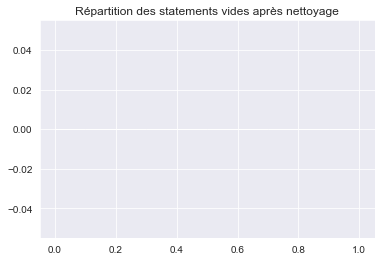

In [152]:
df_empty = df1[df1['statement']==""]
df_empty.hist('Date')
plt.title("Répartition des statements vides après nettoyage")

In [159]:
df1.to_csv('update_version_7.csv')

In [55]:
len(df1[df1['statement _size']==0])

24

In [154]:
df1  = df1.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156082 entries, 0 to 156138
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date               156082 non-null  datetime64[ns]
 1   interlocutor_name  156082 non-null  object        
 2   statement _size    156082 non-null  int64         
 3   statement          156082 non-null  object        
 4   statement_number   156082 non-null  object        
 5   chair_in_charge    156082 non-null  object        
 6   score_academ       156082 non-null  float64       
 7   score_hostile      156082 non-null  float64       
 8   score_econo        156082 non-null  float64       
 9   score_virtue       156082 non-null  float64       
 10  score_vice         156082 non-null  float64       
 11  score_hawkish      156082 non-null  float64       
 12  score_posi         156082 non-null  float64       
 13  score_affi         156082 non-null  float64 

In [7]:
df1.tail()

,Date,interlocutor_name,statement _size,statement,statement_number,chair_in_charge,score_academ,score_hostile,score_econo,score_virtue,...,NUMB,Yes,No,Negate,SureLw,If,NotLw,RspGain,ABS,Causal
156134,2015-12-16,CHAIR YELLEN.,9,You mean that you can ask a question that,statement_2502,CHAIR YELLEN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156135,2015-12-16,MR. WILLIAMS.,25,You just dont opine or bring up the discussion...,statement_2503,CHAIR YELLEN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156136,2015-12-16,MR. EVANS.,16,So it has to be Isnt it true that we need to ....,statement_2504,CHAIR YELLEN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156137,2015-12-16,CHAIR YELLEN.,54,If we dont change the overnight RRP rate in th...,statement_2505,CHAIR YELLEN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
156138,2015-12-16,MR. EVANS.,2,Thank you.,statement_2506,CHAIR YELLEN,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Preprocessing

La base s'arrête en 2014, on va rajouter le scrapping de 2015 avec les codes contenus dans `codes scrapping`.

In [8]:
# add 2015 update
df1.Date = df1.Date.astype('datetime64')

### Chairs

In [155]:
df = df1
pd.unique(df1.chair_in_charge)

array(['CHAIRMAN BURNS', 'CHAIRMAN MILLER', 'CHAIRMAN VOLCKER',
       'CHAIRMAN GREENSPAN', 'CHAIRMAN BERNANKE', 'CHAIR YELLEN'],
      dtype=object)

Text(0.5, 0, 'Chair person')

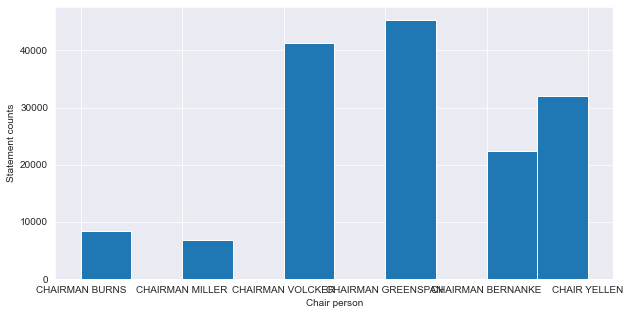

In [156]:
plt.figure(figsize=(10,5))
df['chair_in_charge'].hist()
plt.ylabel('Statement counts')
plt.xlabel('Chair person')

In [20]:
print(len(pd.unique(df['interlocutor_name'])), pd.unique(df['interlocutor_name'])[130:170])


572 ['MS ZICKLER' 'MR SLIFMAN' 'MR ENZLER' 'MS SEGER' 'MR DAVIS' 'MR GRIFFITH'
 'MR GARBARINI' 'VICE CHAIRMAN CORRIGAN' 'MR STERN' 'MR MELZER'
 'MR BOEHNE?' 'MR BLACK?' 'MR RICE?' 'MR PARRY' 'MR JOHNSON' 'MR ANGELL'
 'MR STERN?' 'MR BOHNE' 'MR THIEKE' 'MR HELLER' 'MR PRELL?' 'MR PARRY?'
 'MR HELLER?' 'MR HENDRICKS' 'MR KELLEY' 'CHAIRMAN GREENSPAN'
 'MR EISENMENGER' 'MR EISEMENGER' 'MR HOSKINS' 'MR SMALL' 'MR GUYNN'
 'MR KEEHN?' 'MR JOHNSON?' 'MR KOHN?' 'MS LOVETT' 'MR LAWARE' 'MR PORTER'
 'MR SYRON' 'MR ROSINE' 'MR GREENSPAN']


In [157]:
def name_cleaning(name_list):
    # Removing punctuations in string
    # Using regex
    cleaned = []
    stopname_list=['CHAIRMAN', 'MS', 'VICE', 'MR']
    for name in name_list:
        res = re.sub(r'[^\w\s]', '', name)
        # printing result
        # print("The string after punctuation filter : " + res)
        
        res = ' '.join([word for word in res.split() if word not in stopname_list])
        cleaned.append(res)
    return cleaned
def get_role(name_list):
    role = []
    stopname_list=['CHAIRMAN', 'MS', 'VICE', 'MR']
    for name in name_list:
        res = re.sub(r'[^\w\s]', '', name)
        res = ' '.join([word for word in res.split() if word in stopname_list])
        role.append(res)
        
    return role

In [158]:
#df['role_int']= get_role(df.interlocutor_name.tolist())
df1['interlocutor_name']=name_cleaning(df.interlocutor_name.tolist())

In [26]:
pd.unique(df.interlocutor_name)[130:170]

array(['PATRIKIS', 'MULLINS', 'MCTEER', 'PROMISEL', 'recommended',
       'MATTLINGLY', 'KELLY', 'BROADDUS', 'HOENIG', 'PHILLIPS',
       'MCDONOUGH', 'JORDAN', 'DANKER', 'FISHER', 'WHITE', 'FORESTALL',
       'BEEBE', 'MINEHAN', 'BLINDER', 'YELLEN', 'CONRAD', 'MOSKOW',
       'LANG', 'Mr', 'MOSCOW', 'KRIEGER', 'KOS', 'MEYER', 'RIVLIN', '',
       'MADIGAN', 'FERGUSON', 'GRAMLICH', 'RIVES', 'POOLE', 'GILLUM',
       'WHITESELL', 'VARVEL', 'SPILLENKOTHEN', 'PARKINSON'], dtype=object)

In [27]:
df_small = df.head(40000)
df_small = df_small.groupby('interlocutor_name').agg({'statement':'count'})

<AxesSubplot:ylabel='statement'>

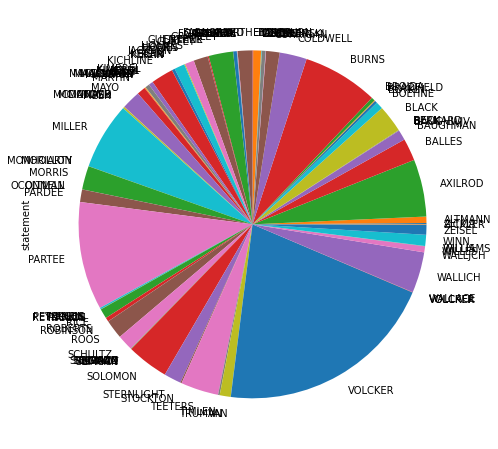

In [28]:
fig = plt.figure(figsize=(8,8))
fig.patch.set_facecolor('white')
df_small.statement.plot.pie()

### Statements

In [29]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.extend(['mr','re', 's', 'it', 'ex', 'in', 'he', 'and', 
             'there', 'however', 'to', 'now', 'to', 'of', 
             'the', 'they', 'but', 'soon', 'film', 'that',
             'who', 'of', 'dont', 'isnt'])


[nltk_data] Downloading package stopwords to /Users/h2jw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [34]:
df.head()

,Date,interlocutor_name,statement _size,statement,statement_number,chair_in_charge,score_acadam,score_hostile,score_econo,score_virtue,...,Yes,No,Negate,SureLw,If,NotLw,RspGain,ABS,Causal,role_int
0,1976-08-17 00:00:00,BURNS,41,we are ready to start our meeting this morning...,statement_0,CHAIRMAN BURNS,0.0,0.04878,0.024390,0.048780,...,0.0,0.02439,0.024390,0.048780,0.000000,0.024390,0.02439,0.024390,0.024390,CHAIRMAN
1,1976-08-17 00:00:00,HOLMES,2,statementsee appendix,statement_1,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,MR
2,1976-08-17 00:00:00,BLACK,27,alan do you think that through realignment of ...,statement_2,CHAIRMAN BURNS,0.0,0.00000,0.037037,0.037037,...,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.074074,0.037037,MR
3,1976-08-17 00:00:00,HOLMES,49,there are two alternatives one that everybody ...,statement_3,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,...,0.0,0.00000,0.020408,0.020408,0.040816,0.020408,0.00000,0.061224,0.020408,MR
4,1976-08-17 00:00:00,BLACK,8,which do you think would be more likely?,statement_4,CHAIRMAN BURNS,0.0,0.00000,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.125000,0.000000,MR


In [30]:
df.statement = df.statement.astype('string')

On va "nettoyer" les statements des STOPWORDS.

In [32]:
df.statement = df.statement.fillna('')
df['statement'] = df['statement'].str.replace('[^\w\s]','') # remove punctuation

df["statement"] = df["statement"].str.lower().str.split() # get words with lowercase 

df['statement'] = df['statement'].apply(lambda x: [item for item in x if item not in stop]) # remove stopwords
df.statement.tail()

/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_22816/2046776006.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['statement'] = df['statement'].str.replace('[^\w\s]','') # remove punctuation


156134                                [mean, ask, question]
156135    [dont, opine, bring, discussion, regarding, in...
156136                         [isnt, true, need, laughter]
156137    [dont, change, overnight, rrp, rate, meeting, ...
156138                                              [thank]
Name: statement, dtype: object

In [40]:
df.statement = df.statement.astype('string')
df['statement'] = df['statement'].str.replace('[^\w\s]','')

/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_22816/3591859878.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['statement'] = df['statement'].str.replace('[^\w\s]','')


In [41]:
df_lda = df
df_lda[['statement']].tail()

,statement
156134,mean ask question
156135,dont opine bring discussion regarding instance...
156136,isnt true need laughter
156137,dont change overnight rrp rate meeting somethi...
156138,thank


## Quelques statistiques descriptives...

- Wordclouds par "Chair in charge"

In [42]:
def nuage_de_mots(text): 
    wordcloud = WordCloud(background_color="white",
                          relative_scaling = 1.0,
                          width=1280, 
                          height=800, 
                          stopwords = STOPWORDS # mots à ne pas prendre en compte dans le nuage
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()   
    

In [43]:
df.statement

0         ready start meeting morning first item busines...
1                                     statementsee appendix
2         alan think realignment currencies european com...
3         two alternatives one everybody goes floats sep...
4                                        think would likely
                                ...                        
156134                                    mean ask question
156135    dont opine bring discussion regarding instance...
156136                              isnt true need laughter
156137    dont change overnight rrp rate meeting somethi...
156138                                                thank
Name: statement, Length: 156139, dtype: string

In [44]:
df_small = df.head(40000)

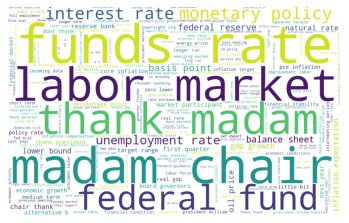

Wordcloud associé à la chair Yellen


In [45]:
df_statement = df.groupby('chair_in_charge')['statement'].apply(' '.join)
nuage_de_mots(df_statement.iloc[[0]][0])  
print("Wordcloud associé à la chair Yellen")

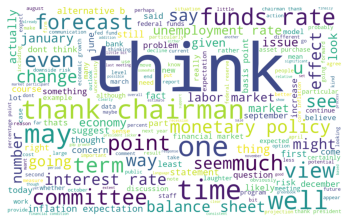

Wordcloud associé à la chair Bernanke


In [46]:
nuage_de_mots(df_statement.iloc[[1]][0]) 
print("Wordcloud associé à la chair Bernanke")

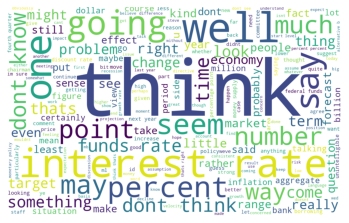

Wordcloud associé à la chair Volcker


In [47]:
nuage_de_mots(df_statement.iloc[[-1]][0]) 
print("Wordcloud associé à la chair Volcker")

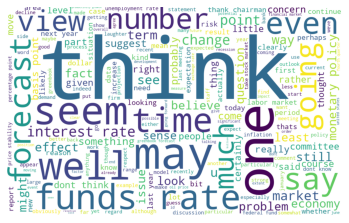

Wordcloud associé à la chair Greenspan


In [62]:
nuage_de_mots(df_statement.iloc[[3]][0]) 
print("Wordcloud associé à la chair Greenspan")

In [61]:
df_statement

chair_in_charge
CHAIR YELLEN          right think ready go dont start simon financia...
CHAIRMAN BERNANKE     welcome everyone year since ive one meetings i...
CHAIRMAN BURNS        ready start meeting morning first item busines...
CHAIRMAN GREENSPAN    longer pause expected laughter id like enterta...
CHAIRMAN MILLER       well join us arrives first start procedural ma...
CHAIRMAN VOLCKER      might say benefit come little executive sessio...
Name: statement, dtype: object

### Tests de LDA 
#### Approche *bag of words*
- LDA sur l'ensemble des statements. 
- LDA sur Chair Burns, Chair Miller et Chair Greenspan

On a considéré comme document l'ensemble des statements ou l'ensemble des statements prononcé sous une chair (Burns, Miller ou Greenspan). 


In [183]:
#!pip install pyldavis

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn


def LDA_fit(series, n_topic): #notre LDA prend en entrée le series.dataframe contenant l'information textuelle 
                                      #et le nombre de topic à modéliser
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=1000)
    tfidf = tfidf_vectorizer.fit_transform(series)

    lda = LatentDirichletAllocation(n_components=n_topic, max_iter=5,
                                  learning_method='online',
                                  learning_offset=50.,
                                  random_state=0)
    lda.fit(tfidf)
    LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=n_topic, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

    tf_feature_names = tfidf_vectorizer.get_feature_names()

    return pyLDAvis.sklearn.prepare(lda, tfidf, tfidf_vectorizer)



def LDA_on_dataset(series, n_topic): #notre LDA prend en entrée le series.dataframe contenant l'information textuelle 
                                      #et le nombre de topic à modéliser
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=1000)
    tfidf = tfidf_vectorizer.fit_transform(series)

    lda = LatentDirichletAllocation(n_components=n_topic, max_iter=5,
                                  learning_method='online',
                                  learning_offset=50.,
                                  random_state=0)
    lda.fit_transform(tfidf)
    LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=n_topic, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

    tf_feature_names = tfidf_vectorizer.get_feature_names()

    return pyLDAvis.sklearn.prepare(lda, tfidf, tfidf_vectorizer)



In [69]:
print('Statement : \n')
pyLDAvis.enable_notebook()
LDA_fit(df_lda.statement, 5)

Statement : 



/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.176382 -0.058112       1        1  47.815049
0      0.147622 -0.116249       2        1  27.682288
1      0.114451 -0.150975       3        1   9.529795
2      0.035591  0.390306       4        1   7.569548
4     -0.474046 -0.064970       5        1   7.403320, topic_info=          Term          Freq         Total Category  logprob  loglift
650  president  10911.000000  10911.000000  Default  30.0000  30.0000
884      thank   6196.000000   6196.000000  Default  29.0000  29.0000
367   governor   4679.000000   4679.000000  Default  28.0000  28.0000
992        yes   3624.000000   3624.000000  Default  27.0000  27.0000
747      right   3601.000000   3601.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
829      start      0.215746    468.705176   Topic5 -11.8674  -5.0804
449    january      0.217290    682.635817   Topic5 -11.8603  -5.4492
92       begin      0.212578    270.431159   Topic5 -11.8822  -4.5452
738   response      0.213096    380.699598   Topic5 -11.8798  -4.8848
132      chair      0.211741   1883.897048   Topic5 -11.8862  -6.4902

[297 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
3         1  0.325896    accept
3         3  0.670684    accept
11        1  0.995011    action
13        1  0.088674  activity
13        2  0.909541  activity
...     ...       ...       ...
992       5  0.999773       yes
995       2  0.995527     yield
998       1  0.155283     youre
998       2  0.000872     youre
998       4  0.843590     youre

[484 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3, 5])

In [70]:
df_burns = df_lda[df_lda.chair_in_charge == 'CHAIRMAN BURNS']
df_miller = df_lda[df_lda.chair_in_charge == 'CHAIRMAN MILLER']

In [72]:
print('Statement Burns : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_burns.statement, 5)

Statement Burns : 



/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.114232  0.015031       1        1  59.400539
0      0.090840  0.166162       2        1  19.202317
4     -0.389078 -0.003229       3        1   9.715417
1      0.097356 -0.247245       4        1   6.352007
3      0.086651  0.069281       5        1   5.329720, topic_info=         Term        Freq       Total Category  logprob  loglift
896     thank  279.000000  279.000000  Default  30.0000  30.0000
994       yes  265.000000  265.000000  Default  29.0000  29.0000
648    please  234.000000  234.000000  Default  28.0000  28.0000
635   percent  174.000000  174.000000  Default  27.0000  27.0000
761     right  188.000000  188.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
404      hope   16.570478   36.270655   Topic5  -4.4359   2.1485
548      mind   15.824191   38.342606   Topic5  -4.4820   2.0468
655  possible   14.972043   36.939736   Topic5  -4.5373   2.0288
851     still   25.576496   66.502909   Topic5  -4.0018   1.9763
706     range   35.626152  124.557443   Topic5  -3.6704   1.6802

[262 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1         1  0.384795  abroad
1         4  0.577193  abroad
1         5  0.064133  abroad
13        1  0.355417     add
13        2  0.023694     add
...     ...       ...     ...
992       5  0.010905    year
994       1  0.030187     yes
994       2  0.015094     yes
994       3  0.950900     yes
994       5  0.003773     yes

[592 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 5, 2, 4])

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [254]:
print('Statement Miller : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_miller.cleaned_statement, 5)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement Miller : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.071625 -0.061479       1        1  65.769742
4     -0.053794  0.296858       2        1  10.731505
3     -0.148441 -0.082027       3        1   9.567390
0      0.339093 -0.026251       4        1   7.659058
1     -0.065233 -0.127100       5        1   6.272304, topic_info=        Term        Freq       Total Category  logprob  loglift
872    thank  247.000000  247.000000  Default  30.0000  30.0000
992      yes  240.000000  240.000000  Default  29.0000  29.0000
141    chuck  109.000000  109.000000  Default  28.0000  28.0000
737    right  119.000000  119.000000  Default  27.0000  27.0000
874    thats  112.000000  112.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
328  foreign   20.028476   50.022509   Topic5  -4.1412   1.8537
563      new   15.653411   34.592611   Topic5  -4.3876   1.9761
482     line   15.689073   35.727537   Topic5  -4.3854   1.9461
178    could   16.514572   96.635508   Topic5  -4.3341   1.0023
958     well   12.956112  159.204653   Topic5  -4.5768   0.2604

[246 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
22        2  0.860648      agenda
24        1  0.979524  aggregates
29        1  0.036834        alan
29        2  0.847191        alan
29        3  0.073669        alan
...     ...       ...         ...
995       1  0.041333        york
995       5  0.909322        york
996       1  0.232631         you
996       2  0.021148         you
996       3  0.740188         you

[404 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 4, 1, 2])

In [256]:
df_greenspan = df_lda[df_lda.chair_in_charge == 'CHAIRMAN GREENSPAN']

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [257]:
print('Statement Greenspan : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_greenspan.cleaned_statement, 5)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement Miller : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.193199  0.015443       1        1  40.456062
0      0.209096  0.008848       2        1  39.608957
3     -0.197378 -0.381319       3        1   6.860028
4      0.155182  0.094060       4        1   6.764059
2     -0.360099  0.262967       5        1   6.310895, topic_info=           Term         Freq        Total Category  logprob  loglift
645   president  4998.000000  4998.000000  Default  30.0000  30.0000
358    governor  2965.000000  2965.000000  Default  29.0000  29.0000
747       right  1108.000000  1108.000000  Default  28.0000  28.0000
886       thank  1075.000000  1075.000000  Default  27.0000  27.0000
887        that   997.000000   997.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
744     revised     0.283578    46.598261   Topic5 -10.4362  -2.3389
991         yes     0.289667  1034.924273   Topic5 -10.4150  -5.4182
949        vice     0.288644   416.676684   Topic5 -10.4185  -4.5120
224  discussion     0.287930   296.978092   Topic5 -10.4210  -4.1758
313       first     0.286796   389.133965   Topic5 -10.4249  -4.4500

[287 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
10        1  0.925301  activity
10        2  0.071177  activity
22        1  0.066081     agree
22        2  0.451174     agree
22        3  0.480797     agree
...     ...       ...       ...
991       2  0.096625       yes
997       1  0.123265       you
997       2  0.876551       you
998       2  0.984522     youre
998       5  0.009467     youre

[461 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 5, 3])

On va chercher à observer/mesurer l'impact d'un changement de chair sur un membre ayant fait plusieurs chairs.

Les chairs se succèdent selon la temporalité suivante : 
- 08/1976 : Chair Burns
- 01/1978 : Chair Miller
- 08/1979 : Chair Volcker
- 08/1987 : Chair Greenspan
- 08/2006 : Chair Bernanke
- 01/2014 : Chair Yellen

Observons arbitrairement les individus tandem entre la chair Volcker et la chair Greenspan puis chair Bernanke et chair Greenspan. 

In [662]:
df.chair_in_charge = df.chair_in_charge.astype('string')
#df.Date = df.Date.astype('datetime64')

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sélection des statements de la chair Volcker et de la chair Greenspan. 

In [65]:
mask = (df.chair_in_charge == "CHAIRMAN VOLCKER") + (df.chair_in_charge == "CHAIRMAN GREENSPAN")
df1  = df[mask]
df1

,Date,interlocutor_name,statement _size,statement,statement_number,chair_in_charge,score_academ,score_hostile,score_econo,score_virtue,...,Yes,No,Negate,SureLw,If,NotLw,RspGain,ABS,Causal,role_int
15170,1979-08-14,VOLCKER,636,might say benefit come little executive sessio...,statement_0,CHAIRMAN VOLCKER,0.007862,0.022013,0.036164,0.051887,...,0.009434,0.000000,0.006289,0.034591,0.018868,0.004717,0.001572,0.034591,0.020440,CHAIRMAN
15171,1979-08-14,WALLICH,21,possible figure unrealized gain loss account t...,statement_1,CHAIRMAN VOLCKER,0.000000,0.000000,0.095238,0.000000,...,0.000000,0.000000,0.047619,0.047619,0.095238,0.000000,0.000000,0.000000,0.095238,MR
15172,1979-08-14,FARNSWORTH,25,governor wallich today dave robinson manager a...,statement_2,CHAIRMAN VOLCKER,0.000000,0.080000,0.040000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,MR
15173,1979-08-14,VOLCKER,11,account talking domestic foreign,statement_3,CHAIRMAN VOLCKER,0.000000,0.000000,0.090909,0.000000,...,0.000000,0.000000,0.090909,0.090909,0.181818,0.000000,0.000000,0.000000,0.090909,CHAIRMAN
15174,1979-08-14,WALLICH,35,domestic foreign side take rule fasb requires ...,statement_4,CHAIRMAN VOLCKER,0.000000,0.000000,0.000000,0.028571,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,MR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101794,2006-01-31,GREENSPAN,28,gather correctly theres real interest reversin...,statement_164,CHAIRMAN GREENSPAN,0.000000,0.035714,0.071429,0.035714,...,0.000000,0.035714,0.035714,0.035714,0.035714,0.035714,0.000000,0.071429,0.071429,CHAIRMAN
101795,2006-01-31,DANKER,185,thank chairman decision go ahead status quo wa...,statement_165,CHAIRMAN GREENSPAN,0.010811,0.005405,0.048649,0.021622,...,0.054054,0.000000,0.005405,0.059459,0.010811,0.000000,0.000000,0.032432,0.016216,MS
101796,2006-01-31,GREENSPAN,19,request federal reserve board engage addressin...,statement_166,CHAIRMAN GREENSPAN,0.052632,0.000000,0.105263,0.052632,...,0.000000,0.000000,0.052632,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,CHAIRMAN
101797,2006-01-31,GREENSPAN,27,federal reserve board voted unanimously accept...,statement_167,CHAIRMAN GREENSPAN,0.037037,0.000000,0.074074,0.037037,...,0.000000,0.000000,0.037037,0.037037,0.000000,0.000000,0.000000,0.037037,0.037037,CHAIRMAN


Sélection des individus ayant prononcé des statements sur les deux chair.

In [131]:
df1['Date_max']= df1.Date
df1.assign(Date_max=df1.Date)
df_interlocutor = df1.groupby('interlocutor_name').agg({'Date':'min', 'Date_max':'max', 'statement':' '.join})

/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_22816/1127751381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date_max']= df1.Date


In [67]:
df_interlocutor.head()


,Date,Date_max,statement
interlocutor_name,,,
,1996-12-17,1997-09-30,president jordan last time looked issue year a...
ALEXANDER,1999-02-03,1999-02-03,main changes forecast international side drive...
ALTMA,1979-09-18,1979-10-06,chairman volcker yes president balles presiden...
ALTMANN,1979-08-14,1982-12-21,yes change authorization foreign currency oper...
ANGELL,1986-02-12,1993-12-21,hesitate make governor seger incorrect point f...


In [68]:
df_interlocutor.Date = df_interlocutor.Date.astype('datetime64')
df_interlocutor.Date_max = df_interlocutor.Date_max.astype('datetime64')

In [97]:
mask_volcker = (df_interlocutor.Date.dt.strftime('%Y-%m') >= '1979-08') & (df_interlocutor.Date_max.dt.strftime('%Y-%m') < '1987-08')
mask_greenspan = (df_interlocutor.Date.dt.strftime('%Y-%m') >= '1987-08') & (df_interlocutor.Date_max.dt.strftime('%Y-%m') < '2006-08')
mask_tandem = (df_interlocutor.Date.dt.strftime('%Y-%m') <= '1987-08') & (df_interlocutor.Date_max.dt.strftime('%Y-%m')< "2006-08")
df_volcker = df_interlocutor[mask_volcker]
df_greenspan = df_interlocutor[mask_greenspan]
df_tandem = df_interlocutor[mask_volcker & mask_greenspan]



In [93]:
df_volcker['length']=df_volcker['Date_max']-df_volcker['Date']
df_volcker['statement_size']=df_volcker.statement.str.len()
df_greenspan['length']=df_greenspan['Date_max']-df_greenspan['Date']
df_greenspan['statement_size']=df_greenspan.statement.str.len()


/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_22816/2953080828.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_volcker['length']=df_volcker['Date_max']-df_volcker['Date']
/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_22816/2953080828.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_volcker['statement_size']=df_volcker.statement.str.len()
/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_22816/2953080828.py:3: SettingWithCopyWarning: 
A value is trying to be se

In [94]:
df_yellen.sort_values(by='length', ascending=False).head()

,Date,interlocutor_name,statement _size,statement,statement_number,chair_in_charge,score_academ,score_hostile,score_econo,score_virtue,...,SureLw,If,NotLw,RspGain,ABS,Causal,role_int,Date_max,length,statement_size


Text(0.5, 1.0, 'Volcker')

<Figure size 1440x720 with 0 Axes>

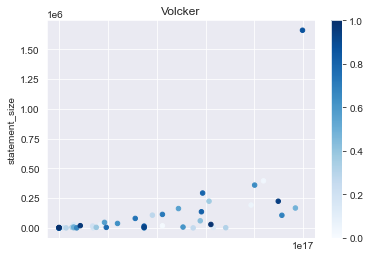

In [79]:
import seaborn as sns
df_volcker.length = df_volcker.length.astype('int')
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
df_volcker.plot.scatter(x='length', y='statement_size', c=np.linspace(0,1, len(df_volcker)), colormap='Blues')
plt.title("Volcker")

Text(0.5, 1.0, 'Greenspan')

<Figure size 1440x720 with 0 Axes>

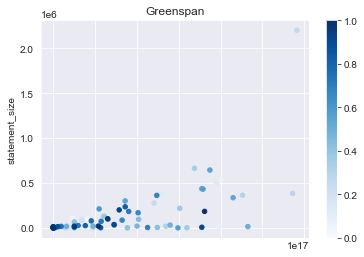

In [83]:
import seaborn as sns
df_greenspan.length = df_greenspan.length.astype('int')
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
df_greenspan.plot.scatter(x='length', y='statement_size', c=np.linspace(0,1, len(df_greenspan)), colormap='Blues')
plt.title("Greenspan")

In [137]:
df.chair_in_charge = df.chair_in_charge.astype('str')
df_yellen = df[df.chair_in_charge=='CHAIR YELLEN']
df_yellen['Date_max']=df_yellen['Date']
df_yellen = df_yellen.groupby('interlocutor_name').agg({'Date':'min', 'Date_max':'max', 'statement':' '.join})
df_yellen['statement_size']=df_yellen.statement.str.len()
df_yellen['length'] = df_yellen.Date_max.dt.date-df_yellen['Date'].dt.date

/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_22816/111669163.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_yellen['Date_max']=df_yellen['Date']


/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_22816/945064797.py:2: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df_yellen.length = df_yellen.length.astype('int')


Text(0.5, 1.0, 'Yellen')

<Figure size 1440x720 with 0 Axes>

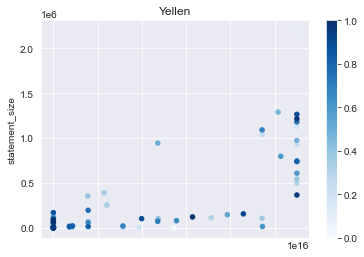

In [138]:
import seaborn as sns
df_yellen.length = df_yellen.length.astype('int')
sns.set_style('darkgrid')
plt.figure(figsize=(20,10))
df_yellen.plot.scatter(x='length', y='statement_size', c=np.linspace(0,1, len(df_yellen)), colormap='Blues')
plt.title("Yellen")

Il n'y a apparemment pas de personnes sur les deux mandats de chair...

In [732]:
df_greenspan['length']=df_greenspan['Date_max']-df_greenspan['Date']
df_greenspan.sort_values('length', ascending=False).head()

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-732-0e1057d93709>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_greenspan['length']=df_greenspan['Date_max']-df_greenspan['Date']


,Date,Date_max,statement,length
interlocutor_name,,,,
GREENSPAN,1987-08-18,2006-01-31,longer pause expected laughter id like enterta...,6741 days
GUYNN,1987-12-16,2006-01-31,first time process fascinating economic develo...,6621 days
MATTINGLY,1989-10-03,2004-06-30,thats youd governor vote directors bank ratify...,5384 days
HOENIG,1991-10-01,2006-01-31,matter fact thats warning chairman want hear d...,5236 days
MCTEER,1991-02-06,2004-09-21,peter said authority pay interest required res...,4976 days


In [734]:
df_greenspan.sort_values('Date_max', ascending=False).head(10)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Date_max,statement,length
interlocutor_name,,,,
LACKER,2004-06-30,2006-01-31,first let add cathys commendations joe linda e...,580 days
FERGUSON,1997-11-12,2006-01-31,thank chairman already said room many reports ...,3002 days
MINEHAN,1994-03-22,2006-01-31,thank chairman trust wont either question comm...,4333 days
STRUCKMEYER,2001-06-27,2006-01-31,dan described data use analysis supply side ec...,1679 days
HOENIG,1991-10-01,2006-01-31,matter fact thats warning chairman want hear d...,5236 days
MOSKOW,1994-09-27,2006-01-31,chairman economic activity seventh district re...,4144 days
GUYNN,1987-12-16,2006-01-31,first time process fascinating economic develo...,6621 days
STOCKTON2,2006-01-31,2006-01-31,thank chairman years back noted briefings coul...,0 days
GREENSPAN,1987-08-18,2006-01-31,longer pause expected laughter id like enterta...,6741 days


In [737]:
print('Statement tandem : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_greenspan.statement, 4)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement tandem : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.015315  0.000004       1        1  94.134821
1      0.005142 -0.000974       2        1   1.987569
3      0.004693  0.000316       3        1   1.939541
2      0.005480  0.000654       4        1   1.938068, topic_info=       Term      Freq     Total Category  logprob  loglift
696    rate  6.000000  6.000000  Default  30.0000  30.0000
639  policy  5.000000  5.000000  Default  29.0000  29.0000
506  market  4.000000  4.000000  Default  28.0000  28.0000
591     one  4.000000  4.000000  Default  27.0000  27.0000
776     see  3.000000  3.000000  Default  26.0000  26.0000
..      ...       ...       ...      ...      ...      ...
776     see  0.035737  3.317098   Topic4  -6.7368  -0.5872
532   model  0.035470  2.144349   Topic4  -6.7443  -0.1584
809   since  0.035542  2.904777   Topic4  -6.7423  -0.4599
659   price  0.035398  3.258793   Topic4  -6.7464  -0.5790
696    rate  0.035364  6.896613   Topic4  -6.7473  -1.3296

[265 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5         1  0.882936      across
19        1  1.015090  aggregates
26        1  0.668315     already
27        1  1.065680        also
32        1  0.786740      amount
...     ...       ...         ...
986       1  1.051057       would
987       1  1.093269     wouldnt
989       1  0.935122        year
990       1  0.809052       years
997       1  0.867681        york

[196 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

On va essayer d'implémenter une LDA sur ces individus pour le chair Greenspan et pour le chair Miller.

In [735]:
print(len(df_tandem))

0


/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [672]:
print('Statement tandem : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_tandem.statement, 5)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement tandem : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.004240 -0.000112       1        1  92.414825
3      0.001094  0.000285       2        1   2.183574
2      0.001063 -0.000668       3        1   2.113081
1      0.000726  0.001188       4        1   1.644753
4      0.001356 -0.000693       5        1   1.643767, topic_info=        Term      Freq     Total Category  logprob  loglift
988    would  2.000000  2.000000  Default  30.0000  30.0000
621  percent  1.000000  1.000000  Default  29.0000  29.0000
886    think  1.000000  1.000000  Default  28.0000  28.0000
695     rate  1.000000  1.000000  Default  27.0000  27.0000
963     well  1.000000  1.000000  Default  26.0000  26.0000
..       ...       ...       ...      ...      ...      ...
679      put  0.011686  0.636141   Topic5  -6.7339   0.1111
510   market  0.011867  0.862259   Topic5  -6.7185  -0.1776
541    money  0.011769  0.908714   Topic5  -6.7268  -0.2384
757   saying  0.011658  0.690036   Topic5  -6.7362   0.0275
79       bad  0.011562  0.581458   Topic5  -6.7445   0.1904

[267 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
30        1  1.717208        ahead
38        1  1.165364  alternative
52        1  1.822767      appears
57        1  1.466562         area
79        1  1.719814          bad
...     ...       ...          ...
963       1  0.773802         well
988       1  0.824679        would
991       1  1.055193         year
993       1  1.131082          yes
997       1  1.506102        youre

[96 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 3, 2, 5])

On va implémenter une fonction cherchant les personnes 'tandem'

In [63]:
def find_overlap_chair(df, CHAIR1, CHAIR2):
    df.Date = df.Date.astype('datetime64')
    time_start = {'CHAIRMAN BURNS': '1976-08',
                'CHAIRMAN MILLER': '1978-01',
                'CHAIRMAN VOLCKER':'1979-08',
                'CHAIRMAN GREENSPAN': '1987-08',
                'CHAIRMAN BERNANKE':'2006-08',
                'CHAIR YELLEN':'2014-01'}
    time_end ={ 'CHAIRMAN BURNS': '1978-01',
                'CHAIRMAN MILLER':'1979-08',
                'CHAIRMAN VOLCKER': '1987-08',
                'CHAIRMAN GREENSPAN':'2006-08',
                'CHAIRMAN BERNANKE':'2014-01', 
                  'CHAIR YELLEN': '2016-01'}
    mask = (df.chair_in_charge == CHAIR1) + (df.chair_in_charge == CHAIR2)
    df1  = df[mask]
    df1['Date_max']= df1.Date
    df1.assign(Date_max=df1.Date)
    df_interlocutor = df1.groupby('interlocutor_name').agg({'Date':'min', 'Date_max':'max', 'statement':' '.join})
    
    mask1 = (df_interlocutor.Date.dt.strftime('%Y-%m') >= time_start[CHAIR1]) & (df_interlocutor.Date_max.dt.strftime('%Y-%m') < time_end[CHAIR1])
    mask2 = (df_interlocutor.Date.dt.strftime('%Y-%m') >= time_start[CHAIR2]) & (df_interlocutor.Date_max.dt.strftime('%Y-%m') < time_end[CHAIR2])
    mask_tandem = (df_interlocutor.Date.dt.strftime('%Y-%m') < time_start[CHAIR2]) 
    df1 = df_interlocutor[mask1]
    df2 = df_interlocutor[mask2]
    df_tandem = df_interlocutor[mask_tandem]
    
    return df1, df2, df_tandem

    

Sur Greenspan/Bernanke

In [64]:
df1, df2, df_tandem = find_overlap_chair(df, 'CHAIRMAN GREENSPAN', 'CHAIRMAN BERNANKE')


/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_49361/943076214.py:2: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  df.Date = df.Date.astype('datetime64')
/var/folders/gq/5vyy06nj12q4lyz8hyd86r580000gn/T/ipykernel_49361/943076214.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date_max']= df1.Date


In [751]:
df_tandem

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Date,Date_max,statement
interlocutor_name,,,
,1996-12-17,1997-09-30,president jordan last time looked issue year a...
ALEXANDER,1999-02-03,1999-02-03,main changes forecast international side drive...
ANGELL,1987-08-18,1993-12-21,guess question ask enough billion might ask bi...
BARRON,2002-06-26,2011-01-26,thank chairman economic conditions southeast r...
BEEBE,1993-12-21,1993-12-21,statementsee appendix might add survey data ev...
...,...,...,...
WILCOX4,2002-01-30,2002-01-30,thank chairman referring material labeled staf...
WILLIAMS,2002-01-30,2014-01-29,taylor rule policymakers would need weigh dete...
WINN,1992-11-17,1999-02-03,unintelligible gonzalez staff auerbach dont kn...


In [65]:
print('Statement tandem : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_tandem.statement, 5)

Statement tandem : 



NameError: name 'pyLDAvis' is not defined

In [758]:
print('Statement Greenspan : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df1.statement, 5)


/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement tandem : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.005510  0.000016       1        1  93.478114
0     -0.000200 -0.000086       2        1   1.879818
1      0.001824 -0.001207       3        1   1.547590
4      0.001691  0.001054       4        1   1.547299
3      0.002195  0.000223       5        1   1.547179, topic_info=          Term      Freq     Total Category  logprob  loglift
988      would  4.000000  4.000000  Default  30.0000  30.0000
897      think  4.000000  4.000000  Default  29.0000  29.0000
431  inflation  3.000000  3.000000  Default  28.0000  28.0000
702       rate  3.000000  3.000000  Default  27.0000  27.0000
630    percent  3.000000  3.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
481       less  0.024366  1.519627   Topic5  -6.7289   0.0357
708     really  0.024581  1.752916   Topic5  -6.7201  -0.0983
54      around  0.024379  1.650054   Topic5  -6.7284  -0.0461
179   continue  0.024229  1.759652   Topic5  -6.7345  -0.1166
135     change  0.024124  1.800248   Topic5  -6.7389  -0.1437

[319 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
2         1  0.932793  accelerating
5         1  0.921015    acceptable
8         1  0.902610           act
14        1  0.886246           add
26        1  0.804104        almost
...     ...       ...           ...
980       1  0.891312         words
988       1  0.913779         would
991       1  1.024383          year
992       1  1.109700         years
999       1  0.853051          zero

[230 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 5, 4])

In [761]:
print('Statement Bernanke : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df2.statement, 5)


/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement Bernanke : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.002684  0.000633       1        1  80.975752
4     -0.000147 -0.002375       2        1  13.857811
3      0.001232  0.000198       3        1   1.821128
2      0.001017  0.000475       4        1   1.716798
1      0.000583  0.001069       5        1   1.628511, topic_info=          Term      Freq     Total Category  logprob  loglift
988      would  2.000000  2.000000  Default  30.0000  30.0000
426  inflation  2.000000  2.000000  Default  29.0000  29.0000
697       rate  2.000000  2.000000  Default  28.0000  28.0000
179      could  1.000000  1.000000  Default  27.0000  27.0000
513     market  2.000000  2.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
532      might  0.023400  1.523790   Topic5  -6.7061  -0.0587
426  inflation  0.023997  2.395620   Topic5  -6.6809  -0.4860
835   spending  0.023031  1.320859   Topic5  -6.7220   0.0683
697       rate  0.023715  2.453975   Topic5  -6.6927  -0.5219
965        way  0.022990  1.278026   Topic5  -6.7238   0.0995

[296 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
12        1  1.034297       actual
19        1  1.079571     advanced
26        1  1.002608        ahead
31        1  0.591493         also
32        1  0.639365  alternative
...     ...       ...          ...
982       1  0.884427      workers
988       1  1.018910        would
990       1  1.060638         year
997       1  0.651039       yields
998       1  0.997070        youre

[216 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 3, 2])

In [766]:
df1, df2, df_tandem = find_overlap_chair(df, 'CHAIRMAN BERNANKE', 'CHAIR YELLEN')

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-765-01c49b146531>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['Date_max']= df1.Date


In [768]:
print('Statement tandem : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_tandem.statement, 5)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement tandem : 



PreparedData(topic_coordinates=              x             y  topics  cluster       Freq
topic                                                    
1      0.019042 -5.467355e-07       1        1  94.391558
4     -0.006301  1.063462e-03       2        1   1.426999
3     -0.001120  1.023700e-04       3        1   1.394967
2     -0.005266 -5.319513e-04       4        1   1.393387
0     -0.006355 -6.333342e-04       5        1   1.393088, topic_info=          Term       Freq      Total Category  logprob  loglift
424  inflation  14.000000  14.000000  Default  30.0000  30.0000
988      would  14.000000  14.000000  Default  29.0000  29.0000
697       rate  12.000000  12.000000  Default  28.0000  28.0000
624    percent  10.000000  10.000000  Default  27.0000  27.0000
609      panel   8.000000   8.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
141  committee   0.039351   5.215558   Topic5  -6.7328  -0.6132
517    markets   0.039256   5.288671   Topic5  -6.7352  -0.6296
522        may   0.039189   5.940300   Topic5  -6.7369  -0.7475
424  inflation   0.039455  14.522014   Topic5  -6.7301  -1.6346
179      could   0.038731   6.787655   Topic5  -6.7486  -0.8926

[364 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         1  1.203193        ability
2         1  1.056540  accommodation
6         1  0.680953        achieve
8         1  0.866912            act
14        1  0.853385            add
...     ...       ...            ...
990       1  0.984893           year
991       1  0.977033          years
992       1  0.845200         yellen
993       1  0.874910            yes
997       1  0.760099         yields

[239 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 4, 3, 1])

In [769]:
print('Statement Bernanke : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df1.statement, 5)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement Bernanke : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.005961 -0.000012       1        1  93.397995
4      0.001140  0.000955       2        1   1.742493
2      0.001554  0.000405       3        1   1.653852
1      0.001283 -0.001261       4        1   1.632528
3      0.001984 -0.000087       5        1   1.573132, topic_info=          Term      Freq     Total Category  logprob  loglift
988      would  4.000000  4.000000  Default  30.0000  30.0000
433  inflation  4.000000  4.000000  Default  29.0000  29.0000
703       rate  3.000000  3.000000  Default  28.0000  28.0000
624    percent  3.000000  3.000000  Default  27.0000  27.0000
636     policy  2.000000  2.000000  Default  26.0000  26.0000
..         ...       ...       ...      ...      ...      ...
191     credit  0.025552  2.041852   Topic5  -6.7192  -0.2288
575   november  0.025029  1.368905   Topic5  -6.7399   0.1504
778        say  0.025058  1.467879   Topic5  -6.7387   0.0817
179       core  0.025054  1.727199   Topic5  -6.7389  -0.0811
926        top  0.024963  1.749274   Topic5  -6.7425  -0.0975

[302 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
12        1  0.974916      actual
19        1  0.987832  adjustment
25        1  0.913460       agree
26        1  1.069924   agreement
30        1  0.789993       along
...     ...       ...         ...
985       1  1.045938     worried
988       1  0.883502       would
990       1  1.063342        year
997       1  0.803390        york
998       1  0.921603       youre

[217 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 2, 4])

In [770]:
print('Statement Yellen : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df2.statement, 5)

/Users/h2jw/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Statement Yellen : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.000776  0.000624       1        1  71.160160
1     -0.001027 -0.000456       2        1  24.394987
4      0.000621  0.000712       3        1   1.482208
2      0.000668  0.000171       4        1   1.481499
3      0.000514 -0.001051       5        1   1.481146, topic_info=               Term      Freq     Total Category  logprob  loglift
809           slack  0.000000  0.000000  Default  30.0000  30.0000
280      everything  0.000000  0.000000  Default  29.0000  29.0000
163  considerations  0.000000  0.000000  Default  28.0000  28.0000
362          growth  0.000000  0.000000  Default  27.0000  27.0000
794            side  0.000000  0.000000  Default  26.0000  26.0000
..              ...       ...       ...      ...      ...      ...
874            tell  0.002028  0.115257   Topic5  -6.7373   0.1720
584         outlook  0.002041  0.126112   Topic5  -6.7309   0.0884
429       investors  0.002018  0.113332   Topic5  -6.7418   0.1844
179         correct  0.002018  0.119752   Topic5  -6.7418   0.1293
135            come  0.002021  0.124318   Topic5  -6.7407   0.0929

[270 rows x 6 columns], token_table=Empty DataFrame
Columns: [Topic, Freq, Term]
Index: [], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 3, 4])

Semblerait-il qu'il y ait un effet du changement de chair sur les topics abordés. On dénote 2 topics principaux sous la chair Yellen contre 1 seul dominant sous Bernanke pour les individus présents sous les deux chair. 

#### Approche avec *word2vec*

### Novelty and transience

$ s^{(j)} = (s_i^{(j)})_i $ list of $ S$ speech topic mixtures with $j$ the chronological order and $i$ the topic. 
- KLD (Kullback Leibler divergence) :
$$ KLD(p|q) = \int_X p \log \frac{p}{q} d\mu $$
- Novelty : 
$$ \mathcal{N}(j) = \frac{1}{w} \sum_{d=1}^w KLD(s^{(j)} | s^{(j-d)})$$ 
- Resonance :
$$ \mathcal{R}(j) =  \frac{1}{w} \big[ \sum_{d=1}^w KLD(s^{(j)} | s^{(j-d)}) - KLD(s^{(j)} | s^{(j+d)}) \big] $$

In [8]:
# Create the list of speech topic mixtures
# Let's see novelty and transience in Greenspan vs Bernanke's speeches.

In [39]:
greenspan = df[df.chair_in_charge == 'CHAIRMAN GREENSPAN']
bernanke = df[df.chair_in_charge =='CHAIRMAN BERNANKE']

Because one person's speech is too short compared to the PNAS experiment, we'll consider the whole intervention of each individual as a speech.

In [40]:
GP = greenspan.groupby('interlocutor_name').agg({'statement _size':'sum', 'statement':' '.join})

In [54]:
speech_Bernanke = GP.loc['BERNANKE'].statement.lower().split()

In [55]:
KLD(speech_Bernanke[10, 15])

TypeError: list indices must be integers or slices, not tuple

GP

In [6]:
def KLD(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [ ]:
def novelty(j, w=50) :
    